### Data preprocessing


Following preprocessing steps were done:

    1) Remove points outside of Beijing
        5th ring road?: https://en.wikipedia.org/wiki/Ring_roads_of_Beijing
        Select specific coordinates for min and max
    2) Remove exact duplicate rows.
    3) Filter out points, which are above speed limit.
        Process trajectories 1-by-1.
    4) Resample - too high sampling frequency.
    5) ??? Performing smoothing - Not done
    6) ??? Create trips - Not done
    7) ??? Trajectory compression - Not done
    
        



In [3]:
import sys
sys.path.append("../") # Add parent dir to source
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # Progress bar

In [4]:
taxi_df = pd.read_pickle("../processed_data/taxi_data.pkl")

## Drop duplicate rows

Drop measurements in one group (taxi_id), which are identical by time. Keep first one. 
This might not be the best way to do it. Might have to keep mean of those lats and coords.


In [5]:
len_taxi_df = len(taxi_df)
taxi_df = taxi_df.drop_duplicates(subset=['taxi_id', 'time'], keep="first")
len_taxi_df_new = len(taxi_df)
print(f"Before: {len_taxi_df}, After: {len_taxi_df_new}, Removed: {len_taxi_df - len_taxi_df_new}")

Before: 17662984, After: 16321494, Removed: 1341490


## Filter by time

To reduce some number of measurements, remove some measurements by checking how often the measurements are made.
My heuristic approach here is to keep 1 measurement every 1 minute. This most likely might need changes depending on usecase.

More correct approach would most likely to be to keep interpolated value (mean coords?). But this is just a heuristic approach here.

    Note: this makes the previous filtering redundant, but I'll keep it if we want to remove this step.



In [40]:
len_taxi_df = len(taxi_df)
taxi_df = taxi_df.set_index("time").groupby(["taxi_id", pd.Grouper(freq='1min')]).first().reset_index()
len_taxi_df_new = len(taxi_df)
print(f"Before: {len_taxi_df}, After: {len_taxi_df_new}, Removed: {len_taxi_df - len_taxi_df_new}")

Before: 16321494, After: 12085915, Removed: 4235579


As we can see, this step already gets rid of quite a bit of measurements.

## Filter by day

For my analysis purposes I will keep only measurements for 4 days Monday-Thursday. This excludes weekend.

    Dates: 4th February to 7th February 2008.
    Looking at the data, I decided not to use 8th February as it was not a complete day in the dataset. 
    Last measurement ~16:00



In [44]:
len_taxi_df = len(taxi_df)
taxi_df = taxi_df[(taxi_df["time"].dt.day >= 4) & (taxi_df["time"].dt.day <= 7)]
len_taxi_df_new = len(taxi_df)
print(f"Before: {len_taxi_df}, After: {len_taxi_df_new}, Removed: {len_taxi_df - len_taxi_df_new}")

Before: 12085915, After: 7645515, Removed: 4440400


We are left with 7.6 million measurements.

## Filter by speed

Remove measurements which would require faster than 300 km/h movement (measuring straight line with Haversine) from previous point.

Need to process trajectory measurements one-by-one. If checking all pairwise distances instantly and remove based on that, might lose too many points.

    E.g. We have measurements Good1 - Bad - Good2. 
        If just checking all pairwise points and remove such points which are too far, then we would
        end up removing both Bad and Good2
        
        Good1 - Bad - Good2 - Good3 -> Good1 - Good3

Therefore, we need to remove the bad measurement and calculate distance from the last good point. With this approach we end up with:
    
    Good1 - Bad - Good2 - Good3 -> Good1 - Good2 - Good3
   
   
Note:
    
    This is rather slow for now.. Routine for 4 days takes ~20 minutes on my laptop. 
    Should be quite a bit faster on better CPU, though. Also, this could easily be ran in parallel
    for each taxi separately. 


In [91]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Source: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km



def calculate_min_speed(lon1, lat1, lon2, lat2, time1, time2):
    """
    Calculate lower bound for speed between two locations described by coords.
    Lower bound is due to the fact that we are moving on shortest line (on a globe)
    Distance used is haversine distance.
    
    return: speed in km/h
    """
    
    # Check that time2 is after time1
    assert time2 > time1
    
    distance = haversine_np(lon1, lat1, lon2, lat2)
    # Calculate time difference in hours
    time_delta_hours = (time2 - time1) / np.timedelta64(1, 'h')

    speed_kmh = distance / time_delta_hours
    return speed_kmh



#calculate_min_speed(taxi_df.iloc[0]["long"], 
#                    taxi_df.iloc[0]["lat"],
#                    taxi_df.iloc[1]["long"],
#                    taxi_df.iloc[1]["lat"],
#                    taxi_df.iloc[0]["time"], 
#                    taxi_df.iloc[1]["time"]
#                   )
    
    
def filter_trajectories_by_speed(df, speed_limit=300):
    """
    Filter measurements by speed
    This function is used to remove anomalies of impossible locations
    E.g. taxi can't move over 300 km/h.
    
    Input: Data.
    Requirements: Taxi data is ordered in by time -> after groupby, the measurements are in
                  correct temporal order.
    
    Example:
    Given a sequence of measurements:
    Good1 - Good2 - Bad1 - Bad2 - Good3 (where BadX are bad measurements)
    
    1) Calculate speed lower bound between Good1 and Good2, see that it is under speed limit
    2) Calculate between Good2 and Bad1, see that it is over limit. Remove Bad1 from sequence
    3) Calculate between Good2 and Bad2, see that it is over limit. Remove Bad2 from sequence
    4) Calculate between Good2 and Good3, see that it is under speed limit.
    
    We are left with Good1 - Good2 - Good3.
    
    Note, that this is still a heuristic. E.g. we can have a mistake if FIRST reading is anomalous.
    Then it can remove whole trajectory. TODO: This is currently unhandled!
    
    Also note, that this way of processing atm is rather slow, but we only have to run it once!
    
    return: filtered trajectory.
    """
    
    bad_measurements = set()
    
    # Get row nr to create mask for later
    df["row_nr"] = np.arange(len(df))
    removed_measurement_count = 0
    
    # Precalculated Haversine distances & speed
    df[["long_prev", "lat_prev", "time_prev"]] = df.groupby('taxi_id')[['long', 'lat', "time"]].shift()
    df["distance_from_prev"] = haversine_np(df["long"], df["lat"], df["long_prev"], df["lat_prev"])
    df["time_delta"] = (df["time"] - df["time_prev"]) / np.timedelta64(1, 'h')
    df["precalc_kmh"] = df["distance_from_prev"] / df["time_delta"]
    # drop unnecessary columns
    df = df.drop(["long_prev", "lat_prev", "time_prev", "time_delta", "distance_from_prev"], axis=1)
    
    
    # We can skip groups where there is no speed above speed limit    
    copy_df = df.groupby("taxi_id").filter(lambda x: (x["precalc_kmh"] > speed_limit).any())
    
    for taxi_id, taxi_group_df in tqdm(copy_df.sort_values("time").groupby("taxi_id"), 
                                       total=len(copy_df["taxi_id"].unique())):
                
        # Always remember last correct measurement. 
        last_measurement = taxi_group_df.iloc[0]
        lm_nr = 0
        # Iterate over all measurements
        for group_row_nr in range(1, len(taxi_group_df)):
                
            measurement = taxi_group_df.iloc[group_row_nr]
            
            # Check if we can use precalculated distance (haven't removed previous measurement)
            if lm_nr + 1 == group_row_nr:
                speed_lb = measurement["precalc_kmh"]
            else:
                # Can't use precalculated distance, calculate from scratch
                speed_lb = calculate_min_speed(
                    last_measurement["long_rad"],
                    last_measurement["lat_rad"],
                    measurement["long_rad"],
                    measurement["lat_rad"],
                    last_measurement["time"],
                    measurement["time"]
                )
                
            # Check if speed is too high
            if speed_lb >= speed_limit:
                # If speed too high, mark this measurement as bad
                bad_measurements.add(measurement["row_nr"])
                removed_measurement_count += 1
                
                if removed_measurement_count % 1000 == 0:
                    print(f"Removed {removed_measurement_count} measurements so far..")
                #print("Found bad measurement", measurement["row_nr"], "taxi_id", taxi_id)
                #print(last_measurement)
                #print(measurement)
                #print(speed_lb)
            else:
                # Update last correct measurement
                last_measurement = taxi_group_df.iloc[group_row_nr]
                lm_nr = group_row_nr

    # Return non-bad measurements
    return df[~(df["row_nr"].isin(bad_measurements))].drop(["row_nr", "precalc_kmh"], axis=1)
    
    


In [93]:
#df = taxi_df   
#speed_limit = 300
#df[["long_prev", "lat_prev", "time_prev"]] = df.groupby('taxi_id')[['long', 'lat', "time"]].shift()
#df["distance_from_prev"] = haversine_np(df["long"], df["lat"], df["long_prev"], df["lat_prev"])
#df["time_delta"] = (df["time"] - df["time_prev"]) / np.timedelta64(1, 'h')
#df["precalc_kmh"] = df["distance_from_prev"] / df["time_delta"]
#df.iloc[:5000].groupby("taxi_id").filter(lambda x: (x["precalc_kmh"] > speed_limit).any())


In [92]:
speed_filtered_df = filter_trajectories_by_speed(taxi_df)

Removed 1000 measurements so far..
Removed 2000 measurements so far..
Removed 3000 measurements so far..
Removed 4000 measurements so far..
Removed 5000 measurements so far..
Removed 6000 measurements so far..
Removed 7000 measurements so far..
Removed 8000 measurements so far..
Removed 9000 measurements so far..
Removed 10000 measurements so far..
Removed 11000 measurements so far..
Removed 12000 measurements so far..
Removed 13000 measurements so far..



In [97]:
# Save results after long calculations ...
#speed_filtered_df.to_pickle("../processed_data/speed_filtered_data.pkl")
speed_filtered_df = pd.read_pickle("../processed_data/speed_filtered_data.pkl")

In [99]:

print(f"Before: {len(taxi_df)}, After: {len(speed_filtered_df)}, Removed: {len(taxi_df) - len(speed_filtered_df)}")

Before: 7645515, After: 7631689, Removed: 13826


## Remove points outside Beijing

When playing around with data I saw that there were plenty of points outside of Beijing. Some were obvious mistakes, such as measurements nearby Sao Tome Principe (west coast of Africa).

Using http://www.automatingosint.com/blog/geographic-bounding-box-drawing-tool/, I selected a bounding box to find minimum and maximum latitudes and longitudes to keep data only within the 5th ring of Beijing:

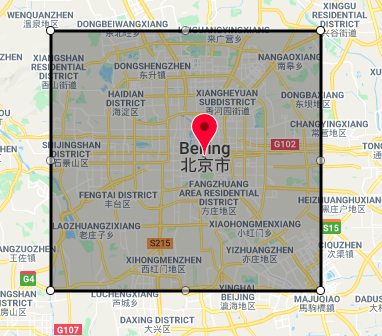

    Minimum latitude: 39.76158
    Maximum latitude: 40.03603
    Minimum longitude: 116.19549
    Maximum longitude: 116.56628


In [100]:
min_lat = 39.76158
max_lat = 40.03603
min_long = 116.19549
max_long = 116.56628

def filter_df_by_coords(df: pd.DataFrame, 
                        min_long: np.float64, 
                        min_lat: np.float64, 
                        max_long: np.float64, 
                        max_lat: np.float64) -> pd.DataFrame:
    """
    Filter dataframe by max and min coordinates. min & max longitude and latitude describe 
    a bounding box.
    
    Input: dataframe with columns long (longitude) and lat (latitude)    
    Return: dataframe with measurements, such that:
        min_long <= long <= max_long
        min_lat <= lat <= max_lat
    """
    
    return df[(min_long <= df["long"]) & (df["long"] <= max_long) & 
              (min_lat <= df["lat"]) & (df["lat"] <= max_lat)]
    

len_taxi_df = len(speed_filtered_df)
taxi_df = filter_df_by_coords(speed_filtered_df, min_long, min_lat, max_long, max_lat)
len_taxi_df_new = len(taxi_df)

print(f"Before: {len_taxi_df}, After: {len_taxi_df_new}, Removed: {len_taxi_df - len_taxi_df_new}")   

Before: 7631689, After: 5367054, Removed: 2264635


In [101]:
# This is the final dataset we will be working with

taxi_df.to_pickle("../processed_data/fully_processed.pkl")

Remaining number of measurements is ~5.3 million